In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
from datetime import datetime, date

## Preamble

In [11]:
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
all_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(mdwarfs): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    all_mdwarfs.append(df)
    
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles) 

  0%|          | 0/225536 [00:00<?, ?it/s]

In [8]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles) 
def convert_to_usable(sc_cubes, mass_index):
    target_mass = sc_cubes["meta"]["reference_masses"][mass_index]
    
    out_sc_cube = {}
    out_sc_cube["data"] = sc_cubes["data"][target_mass]
    out_sc_cube["meta"] = {}
    out_sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
    out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][mass_index])
    out_sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
    out_sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]
    
    out_catalogue = []
    for i in range(3):
        out_catalogue = out_catalogue + sc_cubes["meta"]["memory_reduced_catalogue"][mass_index][i]

    # pull out only what we need
    memory_reduced = []
    relevant_list = ["parallax", "mass", "solution_type", "phot_g_mean_mag"]
    for row in out_catalogue: 
        df = dict()
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        memory_reduced.append(df)
    
    return out_sc_cube, memory_reduced

def mass_binned_data(sc_cubes, catalogue, mass_binned=False, p_model=(4,2), q_model=0, model_cube_size=(15,15), scale=5):
    synth_results = []

    for mass_index in tqdm(range(len(mass_lims))):
        temp_catalogue = []
        for _, obj in enumerate(catalogue):
            if mass_index == 0:
                if obj["mass"] < mass_lims[0]:
                    temp_catalogue.append(obj)
            else:
                if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                    temp_catalogue.append(obj)
        
        # reduce to only mandatory objects to save on memory
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in temp_catalogue:
            df = dict()
            df["mass_index"] = mass_index
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        
        model_cube = Sampler.create_model_cube(model_cube_size, p_model=p_model, q_model=q_model)
        out_sc_cube = sc_cubes
        if mass_binned:
            out_sc_cube, _ = convert_to_usable(sc_cubes, mass_index)
        synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
        _, _ = synthsampler.binarity(resolution=1000, scale=scale, verbose=False)
        synth_results.append(synthsampler.fb_estimator())
        print(f'{synthsampler.fb_estimator()[0]*100:.2f}')
    synth_results = np.array(synth_results)
    return synth_results

def generate_plot(synth_results, target_fb=None):
    plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
    if target_fb is not None:
        plt.axhline(y=target_fb, c="green", linestyle="--");

# Constant Binarity

In [14]:
indata = pickle.load(open("./massive_data/2026-01-20-reference.pkl", "rb"))
data_const_fb = indata["data"]

In [16]:
bincount = 0
solcount = 0
for row in tqdm(data_const_fb):
    if row["is_binary"]:
        if row["period"] > 100 and row["period"] < 1000:
            bincount += 1
            if row["solution_type"] == 12:
                solcount += 1
print(f"Binary count: {bincount}, Solution type 12 count: {solcount} | ({solcount/bincount*100:.2f}%))")

  0%|          | 0/250000 [00:00<?, ?it/s]

Binary count: 12428, Solution type 12 count: 451 | (3.63%))


In [13]:
indata["meta"]

{'object_count': 250000,
 'binary_fraction': 0.3,
 'binarity_model': 'None',
 'period_model': (4, 1.3),
 'mass_model': 0.5,
 'ecc_type': 'turnover'}

In [17]:
sc_cubes = pickle.load(open("./data/2026-01-16-mdwarf_mbins_3plx_turnover.pkl", "rb"))
synth_results = mass_binned_data(sc_cubes, data_const_fb, mass_binned=True, p_model=(4,1.3), q_model=0.5, model_cube_size=(35,25), scale=3)

  0%|          | 0/10 [00:00<?, ?it/s]

29.68
32.08
31.98
32.46
30.64
31.31
31.69
31.41
30.35
32.17


In [19]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.21 Reference synthetic data. Mass binned results for mdwarfs with parallax cuts and 3-parameter luminosity function with turnover. p=(4,1.3), q=0.5, model cube size (25,15), scale=2."
outdata["data"] = dict()
outdata["data"] = synth_results

outfile = open(f'./plot_data/{date.today()}-reference_mass_binned_binarity.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

In [10]:
synth_results = pickle.load(open("./plot_data/2026-01-21-reference_mass_binned_binarity.pkl", "rb"))["data"]

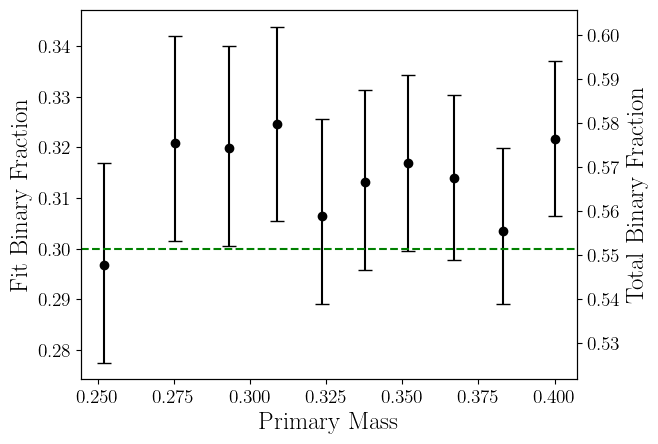

In [18]:
a = Sampler.area_in_range_powerlaw((0.05,1), 0.5)/Sampler.area_in_range_powerlaw((0.05,0.5), 0.5)
# percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
# masses = np.array([t["mass"] for t in all_mdwarfs])
# mass_lims = np.percentile(masses, percentiles) 
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', c="k", zorder=2);
plt.axhline(y=0.3, c="green", linestyle="--");
plt.xlabel("Primary Mass");
plt.ylabel("Fit Binary Fraction");
ymin, ymax = plt.ylim()
ax = plt.twinx();
ax.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a));
ax.set_ylabel("Total Binary Fraction");

# Variable Binarity

## Compute Binarities

In [12]:
data_test = pickle.load(open("./massive_data/2026-01-20-variable_binarity.pkl", "rb"))["data"]
print(pickle.load(open("./massive_data/2026-01-20-variable_binarity.pkl", "rb"))["meta"])

{'object_count': 250000, 'binary_fraction': None, 'binarity_model': '<function bin_frac at 0x7d73ba500a60>', 'period_model': (4, 1.3), 'mass_model': 0.5, 'ecc_type': 'turnover'}


In [13]:
counters = np.zeros(len(mass_lims))
orb_counters = np.zeros(len(mass_lims))
highr_counters = np.zeros(len(mass_lims))
lens = np.zeros(len(mass_lims))
for mass_index in tqdm(range(len(mass_lims))):
    counter = 0
    orb_counter = 0
    highr_counter = 0
    temp_catalogue = []
    for _, obj in enumerate(data_test):
        if mass_index == 0:
            if obj["mass"] < mass_lims[0]:
                temp_catalogue.append(obj)
                if obj["is_binary"]:
                    counter += 1
                    if obj["solution_type"] > 0:
                        highr_counter += 1
                    if obj["solution_type"] > 5:
                        orb_counter += 1
        else:
            if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                temp_catalogue.append(obj)
                if obj["is_binary"]:
                    counter += 1
                    if obj["solution_type"] > 0:
                        highr_counter += 1
                    if obj["solution_type"] > 5:
                        orb_counter += 1
        
    print(f'{counter/len(temp_catalogue)*100:.2f}, {highr_counter/len(temp_catalogue)*100:.2f}, {orb_counter/len(temp_catalogue)*100:.2f}')

    counters[mass_index] = counter
    orb_counters[mass_index] = orb_counter
    highr_counters[mass_index] = highr_counter
    lens[mass_index] = len(temp_catalogue)
refrates = counters/lens
#plt.plot(mass_lims, orb_counters/highr_counters, color="forestgreen");

  0%|          | 0/10 [00:00<?, ?it/s]

29.06, 3.74, 0.45
32.90, 4.21, 0.56
35.64, 4.78, 0.74
37.26, 5.06, 0.83
39.83, 5.44, 1.01
41.85, 6.82, 1.38
42.76, 7.35, 1.71
45.01, 7.97, 1.83
46.76, 9.07, 2.21
49.24, 10.08, 2.84


In [14]:
sc_cubes = pickle.load(open("./data/2026-01-16-mdwarf_mbins_3plx_turnover.pkl", "rb"))
synth_results = mass_binned_data(sc_cubes, data_test, mass_binned=True, p_model=(4,1.3), q_model=0.5, model_cube_size=(35,25), scale=3)

  0%|          | 0/10 [00:00<?, ?it/s]

31.60
34.67
37.46
37.65
38.04
44.38
44.47
45.53
47.74
49.38


In [16]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.21 linear binary fraction increase"
outdata["data"] = dict()
outdata["data"] = synth_results, refrates

outfile = open(f'./plot_data/{date.today()}_variable_binarity_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

## Make Plot

In [2]:
synth_results, refrates = pickle.load(open("./plot_data/2026-01-21_variable_binarity_test.pkl", "rb"))["data"]

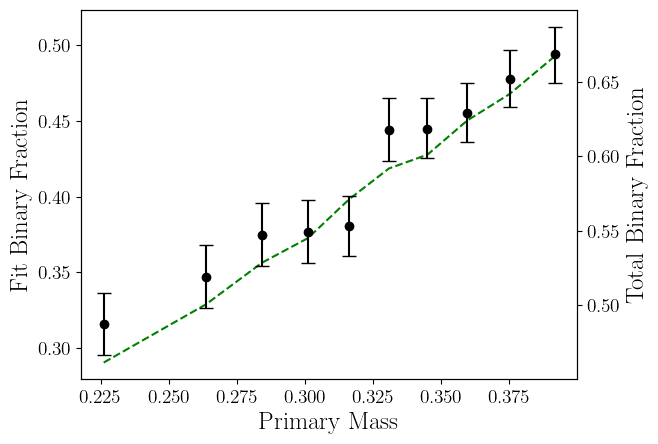

In [15]:
a = Sampler.area_in_range_powerlaw((0.05,1), 0)/Sampler.area_in_range_powerlaw((0.05,0.5), 0)
percentiles_b = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])-10
masses = np.array([t["mass_single"] for t in mdwarfs])
mass_lims_b = np.percentile(masses, percentiles_b)
bin_centers = (mass_lims_b[1:] + mass_lims_b[:-1]) / 2

plt.errorbar(bin_centers, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(bin_centers, synth_results[:,0], marker='o', c="k", zorder=2);
plt.plot(bin_centers, refrates, c="green", linestyle="--", zorder=0);
#plt.axhline(y=0.3, c="green", linestyle="--");
plt.xlabel("Primary Mass");
plt.ylabel("Fit Binary Fraction");
ymin, ymax = plt.ylim()
ax = plt.twinx();
ax.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a));
ax.set_ylabel("Total Binary Fraction");

# Combined plot

In [3]:
import style

In [5]:
flat_synth_results = pickle.load(open("./plot_data/2026-01-21-reference_mass_binned_binarity.pkl", "rb"))["data"]
var_synth_results, refrates = pickle.load(open("./plot_data/2026-01-21_variable_binarity_test.pkl", "rb"))["data"]

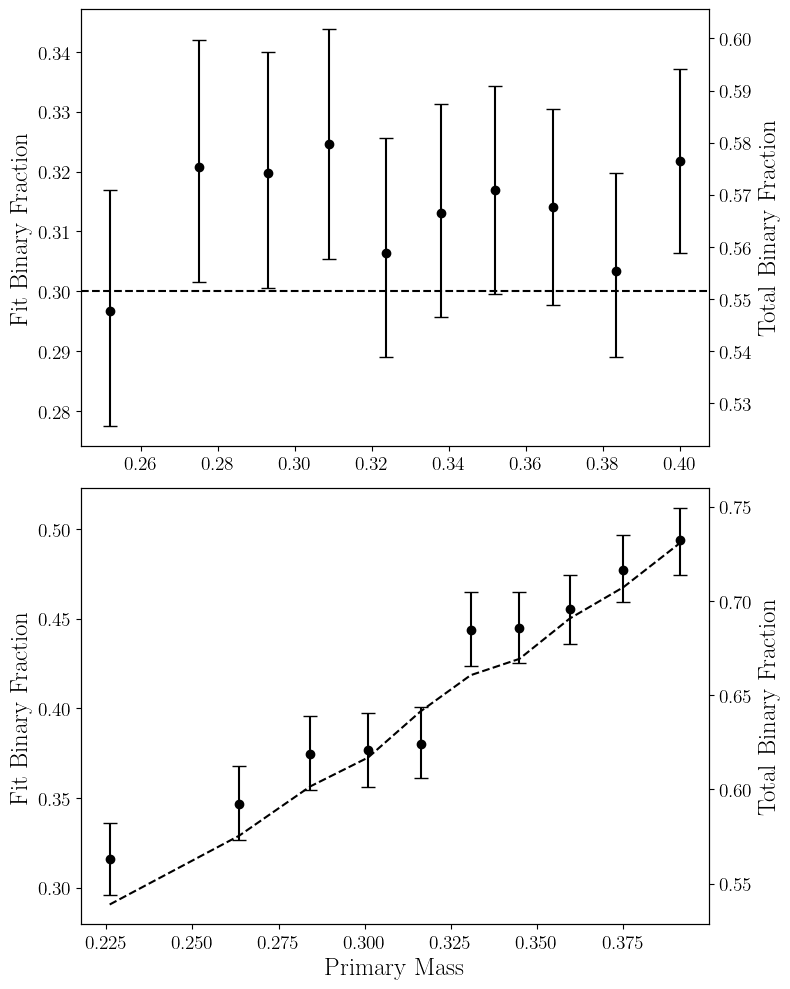

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# precompute the stuff
percentiles_b = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])-10
masses = np.array([t["mass_single"] for t in mdwarfs])
mass_lims_b = np.percentile(masses, percentiles_b)
bin_centers = (mass_lims_b[1:] + mass_lims_b[:-1]) / 2
a = Sampler.area_in_range_powerlaw((0.05,1), 0.5)/Sampler.area_in_range_powerlaw((0.05,0.5), 0.5)

# First panel: flat binarity
ax1.errorbar(mass_lims, flat_synth_results[:,0], yerr=(flat_synth_results[:,2], flat_synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1)
ax1.scatter(mass_lims, flat_synth_results[:,0], marker='o', c="k", zorder=2)
ax1.axhline(y=0.3, c="k", linestyle="--")
ax1.set_ylabel("Fit Binary Fraction")
ax1_twin = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax1_twin.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a))
ax1_twin.set_ylabel("Total Binary Fraction")

# Second panel: variable binarity
ax2.errorbar(bin_centers, var_synth_results[:,0], yerr=(var_synth_results[:,2], var_synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1)
ax2.scatter(bin_centers, var_synth_results[:,0], marker='o', c="k", zorder=2)
ax2.plot(bin_centers, refrates, c="k", linestyle="--", zorder=0)
ax2.set_xlabel("Primary Mass")
ax2.set_ylabel("Fit Binary Fraction")
ax2_twin = ax2.twinx()
ymin, ymax = ax2.get_ylim()
ax2_twin.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a))
ax2_twin.set_ylabel("Total Binary Fraction")

plt.tight_layout()
plt.savefig("./plots/2026-01-21-binarity.png", dpi=800)